# Plot the cumulative weight decay and approximate model weight composition

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# disable type 3 fonts
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# increase font size
plt.rcParams.update({'font.size': 18})

# smaller font for axis ticks
plt.rcParams.update({'xtick.labelsize': 14})
plt.rcParams.update({'ytick.labelsize': 14})

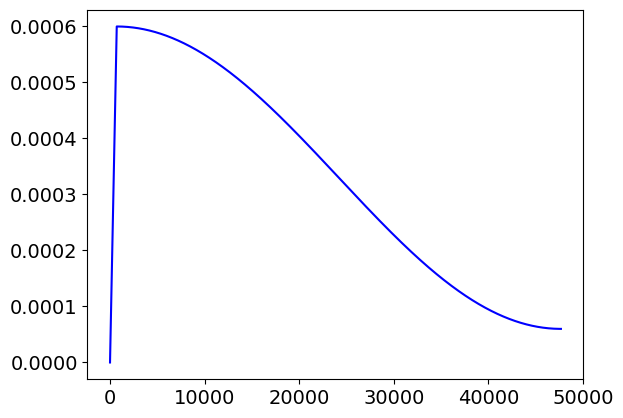

In [2]:
# cosine learning rate schedule
def cosine_lr_schedule(step, total_steps, warmup_steps=700, max_lr=6e-4, min_lr=6e-5):
    """Returns the learning rate at step."""
    if step < warmup_steps:
        return max_lr * step / warmup_steps
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos((step - warmup_steps) / (total_steps - warmup_steps) * np.pi))

steps = 47683
lrs = [cosine_lr_schedule(step, steps) for step in range(steps)]
plt.plot(lrs, linestyle='-', color='b')

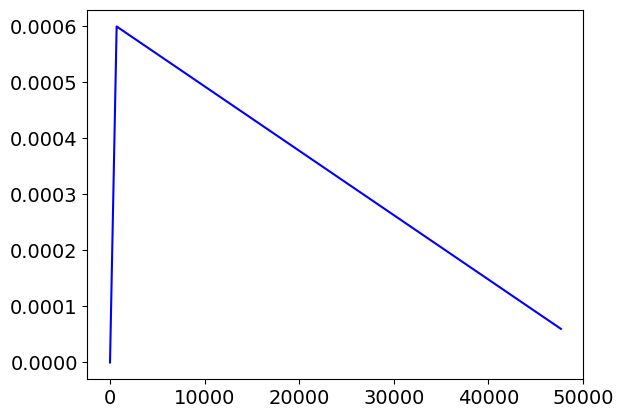

In [3]:
# linear learning rate schedule
def linear_lr_schedule(step, total_steps, warmup_steps=700, max_lr=6e-4, min_lr=6e-5):
    """Returns the learning rate at step."""
    if step < warmup_steps:
        return max_lr * step / warmup_steps
    return min_lr + (max_lr - min_lr) * (1 - (step - warmup_steps) / (total_steps - warmup_steps))

steps = 47683
lrs = [linear_lr_schedule(step, steps) for step in range(steps)]
plt.plot(lrs, linestyle='-', color='b')

In [4]:
def get_adamw_decay_factors(step_start, step_end, total_steps, weight_decay, warmup_steps=700, max_lr=6e-4, min_lr=6e-5, get_lr = cosine_lr_schedule):
    """returns the factors by how much the weights are decayed from start step to end step."""
    per_step_decay_factors = []
    for step in range(step_start, step_end):
        lr = get_lr(step, total_steps, warmup_steps, max_lr, min_lr)
        per_step_decay_factors.append(1 - lr * weight_decay)
    return np.cumprod(per_step_decay_factors)

def model_composition_plot(model_norm):
    # Use the default matplotlib color cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Adjust the figure size for a long bar (width-to-height ratio)
    fig, ax = plt.subplots(figsize=(10, 1))  # width=10, height=1 for a long, thin bar

    # Plot a single horizontal bar composed of the segments
    ax.barh(0, model_norm[0], color=colors[0], edgecolor='black')
    for i in range(1, len(model_norm)):
        ax.barh(0, model_norm[i], left=np.sum(model_norm[:i]), color=colors[i], edgecolor='black')

    # Remove axes
    ax.axis('off')

### 124M 1x

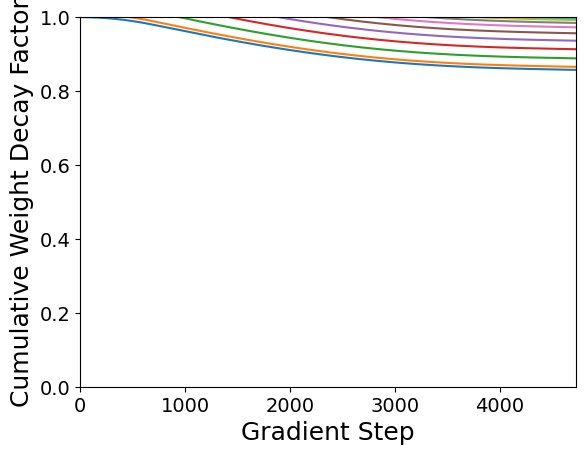

In [5]:
max_lr = 6.0E-4
min_lr = 6.0E-5
warmup_steps = 700
weight_decay = 0.1
total_steps = 4730

# plot the decay after 0%; 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90% of the steps, all in one plot with one line per percentage
for i in range(0, 100, 10):
    step_start = int(i / 100 * total_steps)
    decay_factor = get_adamw_decay_factors(step_start, total_steps, total_steps, weight_decay, warmup_steps, max_lr, min_lr, get_lr=cosine_lr_schedule)
    x = np.arange(step_start, total_steps)
    plt.plot(x, decay_factor, linestyle='-')
plt.ylim(0, 1)
plt.xlim(0, total_steps)
# plt.legend(["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"])
plt.xlabel("Gradient Step")
plt.ylabel("Cumulative Weight Decay Factor")

# save the plot
plt.savefig("figures/decays/124_1x_Chinchilla.pdf")
plt.show()

Step 0 - Step 473,  0.096, 0.859
Step 473 - Step 946,  0.261, 0.876
Step 946 - Step 1419,  0.274, 0.901
Step 1419 - Step 1892,  0.249, 0.925
Step 1892 - Step 2365,  0.212, 0.947
Step 2365 - Step 2838,  0.167, 0.965
Step 2838 - Step 3311,  0.121, 0.979
Step 3311 - Step 3784,  0.079, 0.989
Step 3784 - Step 4257,  0.048, 0.995
Step 4257 - Step 4730,  0.031, 0.999
[0.05761272 0.16032443 0.1730981  0.16169204 0.14075412 0.11314971
 0.08300219 0.05499053 0.03350158 0.02187457]


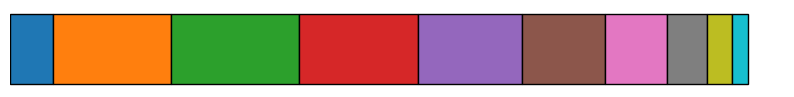

In [6]:
model_norm = []
for i in range(0, 100, 10):
    step_start = int(i / 100 * total_steps)
    step_end = int((i+10) / 100 * total_steps) # we look at 10% of the steps
    # now sum all the learnig rates from step_start to step_end
    lr_sum = 0
    for step in range(step_start, step_end):
        lr_sum += cosine_lr_schedule(step, total_steps, warmup_steps, max_lr, min_lr)
    # approximate the decay by using the middle step of the interval
    decay_factor = get_adamw_decay_factors(int((step_start+step_end)/2), total_steps, total_steps, weight_decay, warmup_steps, max_lr, min_lr, get_lr=cosine_lr_schedule)
    print(f"Step {step_start} - Step {step_end},  {lr_sum:.3f}, {decay_factor[-1]:.3f}")
    #print(f"Decay factor: {decay_factor[-1]}")
    model_norm.append(decay_factor[-1] * lr_sum)
model_norm = np.array(model_norm) / np.sum(model_norm)
print(model_norm)

# make a chart with bars of the right size for each decile of model norm
model_composition_plot(model_norm)
plt.savefig("figures/decays/124_1x_Chinchilla_composition.pdf")


### 124M 15x

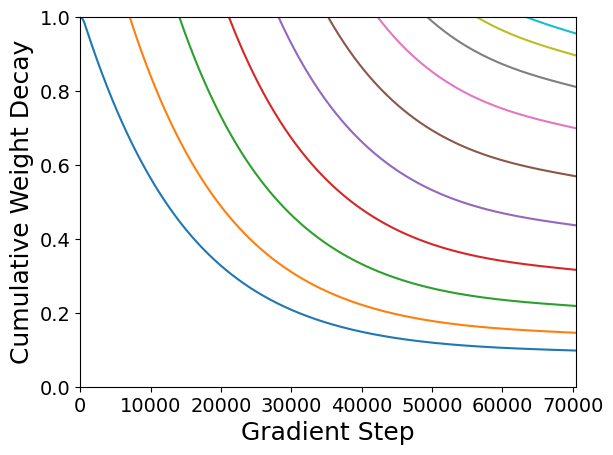

In [7]:
max_lr = 6.0E-4
min_lr = 6.0E-5
warmup_steps = 700
weight_decay = 0.1
total_steps = 47000 // 10 * 15

# plot the decay after 0%; 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90% of the steps, all in one plot with one line per percentage
for i in range(0, 100, 10):
    step_start = int(i / 100 * total_steps)
    decay_factor = get_adamw_decay_factors(step_start, total_steps, total_steps, weight_decay, warmup_steps, max_lr, min_lr, get_lr=cosine_lr_schedule)
    x = np.arange(step_start, total_steps)
    plt.plot(x, decay_factor, linestyle='-')
plt.ylim(0, 1)
plt.xlim(0, total_steps)
# plt.title("124M 15x Chinchilla Cumulative Weight Decay")
 # plt.legend(["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"])
plt.xlabel("Gradient Step")
plt.ylabel("Cumulative Weight Decay")

# save figure
plt.savefig("figures/124M_15x_wd.pdf")
plt.show()

Step 0 - Step 7050,  3.996, 0.118
Step 7050 - Step 14100,  4.038, 0.179
Step 14100 - Step 21150,  3.698, 0.264
Step 21150 - Step 28200,  3.221, 0.374
Step 28200 - Step 35250,  2.655, 0.502
Step 35250 - Step 42300,  2.057, 0.636
Step 42300 - Step 49350,  1.485, 0.758
Step 49350 - Step 56400,  0.997, 0.857
Step 56400 - Step 63450,  0.642, 0.929
Step 63450 - Step 70500,  0.455, 0.979
[0.05231677 0.08001025 0.10809865 0.13328447 0.14750948 0.14459928
 0.12451969 0.09451456 0.06591135 0.0492355 ]


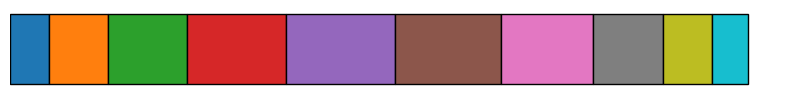

In [8]:
# make a figure that tell us how the final model weights are composed of the gradient updates seen at different steps
max_lr = 6.0E-4
min_lr = 6.0E-5
warmup_steps = 700
weight_decay = 0.1
total_steps = 47000 // 10 * 15
model_norm = []
for i in range(0, 100, 10):
    step_start = int(i / 100 * total_steps)
    step_end = int((i+10) / 100 * total_steps) # we look at 10% of the steps
    # now sum all the learnig rates from step_start to step_end
    lr_sum = 0
    for step in range(step_start, step_end):
        lr_sum += cosine_lr_schedule(step, total_steps, warmup_steps, max_lr, min_lr)
    # approximate the decay by using the middle step of the interval
    decay_factor = get_adamw_decay_factors(int((step_start+step_end)/2), total_steps, total_steps, weight_decay, warmup_steps, max_lr, min_lr, get_lr=cosine_lr_schedule)
    print(f"Step {step_start} - Step {step_end},  {lr_sum:.3f}, {decay_factor[-1]:.3f}")
    #print(f"Decay factor: {decay_factor[-1]}")
    model_norm.append(decay_factor[-1] * lr_sum)
model_norm = np.array(model_norm) / np.sum(model_norm)
print(model_norm)

# make a chart with bars of the right size for each decile of model norm
model_composition_plot(model_norm)

plt.savefig("figures/124M_15x_model_composition.pdf", bbox_inches='tight')

### 1.6B 1x

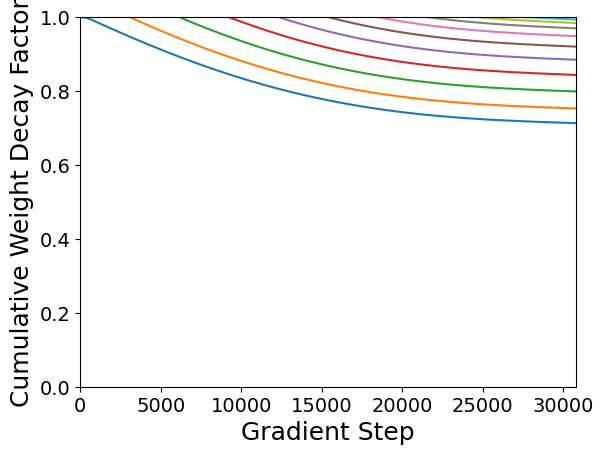

Step 0 - Step 3080,  0.544, 0.730
Step 3080 - Step 6160,  0.592, 0.776
Step 6160 - Step 9240,  0.544, 0.822
Step 9240 - Step 12321,  0.476, 0.865
Step 12321 - Step 15401,  0.393, 0.903
Step 15401 - Step 18481,  0.305, 0.935
Step 18481 - Step 21562,  0.220, 0.960
Step 21562 - Step 24642,  0.147, 0.978
Step 24642 - Step 27722,  0.094, 0.989
Step 27722 - Step 30803,  0.066, 0.997
[0.13837293 0.16009216 0.15586018 0.14338905 0.12367952 0.09929697
 0.07358006 0.05016757 0.03250184 0.02305971]


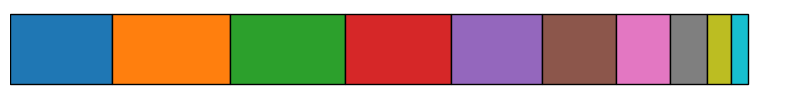

In [9]:
max_lr = 2.0E-4
min_lr = 2.0E-5
warmup_steps = 700
weight_decay = 0.1
total_steps = 30803

# plot the decay after 0%; 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90% of the steps, all in one plot with one line per percentage
for i in range(0, 100, 10):
    step_start = int(i / 100 * total_steps)
    decay_factor = get_adamw_decay_factors(step_start, total_steps, total_steps, weight_decay, warmup_steps, max_lr, min_lr, get_lr=cosine_lr_schedule)
    x = np.arange(step_start, total_steps)
    plt.plot(x, decay_factor, linestyle='-')
plt.ylim(0, 1)
plt.xlim(0, total_steps)
# plt.title("1.6B 1x Chinchilla Cumulative Weight Decay")
#plt.legend(["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"])
plt.xlabel("Gradient Step")
plt.ylabel("Cumulative Weight Decay Factor")
# save figure
plt.savefig("figures/decays/1.6B_1x_Chinchilla.pdf")
plt.show()

model_norm = []
for i in range(0, 100, 10):
    step_start = int(i / 100 * total_steps)
    step_end = int((i+10) / 100 * total_steps) # we look at 10% of the steps
    # now sum all the learnig rates from step_start to step_end
    lr_sum = 0
    for step in range(step_start, step_end):
        lr_sum += cosine_lr_schedule(step, total_steps, warmup_steps, max_lr, min_lr)
    # approximate the decay by using the middle step of the interval
    decay_factor = get_adamw_decay_factors(int((step_start+step_end)/2), total_steps, total_steps, weight_decay, warmup_steps, max_lr, min_lr, get_lr=cosine_lr_schedule)
    print(f"Step {step_start} - Step {step_end},  {lr_sum:.3f}, {decay_factor[-1]:.3f}")
    #print(f"Decay factor: {decay_factor[-1]}")
    model_norm.append(decay_factor[-1] * lr_sum)
model_norm = np.array(model_norm) / np.sum(model_norm)
print(model_norm)

# make a chart with bars of the right size for each decile of model norm
model_composition_plot(model_norm)
plt.savefig("figures/decays/1.6B_1x_Chinchilla_composition.pdf")

## OLMo 7B

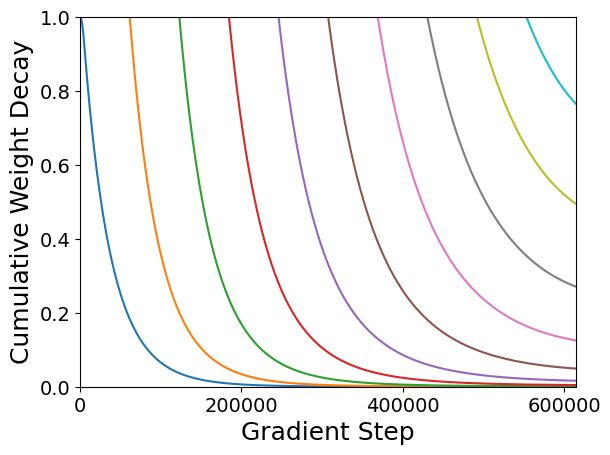

In [10]:
max_lr = 3.0E-4
min_lr = 3.0E-5
warmup_steps = 5000
weight_decay = 0.1
total_steps = 615000

# plot the decay after 0%; 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90% of the steps, all in one plot with one line per percentage
for i in range(0, 100, 10):
    step_start = int(i / 100 * total_steps)
    decay_factor = get_adamw_decay_factors(step_start, total_steps, total_steps, weight_decay, warmup_steps, max_lr, min_lr, get_lr=linear_lr_schedule)
    x = np.arange(step_start, total_steps)
    plt.plot(x, decay_factor, linestyle='-')
plt.ylim(0, 1)
plt.xlim(0, total_steps)
# plt.title("OLMo 7B Cumulative Weight Decay")
# plt.legend(["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"])
plt.xlabel("Gradient Step")
plt.ylabel("Cumulative Weight Decay")

# x axis steps
x = np.arange(0, total_steps, 200000)
plt.xticks(x, x)

# save figure
plt.savefig("figures/OLMo_7B_wd.pdf")
plt.show()

## Llama 405B

#### "We pre-train Llama 3 405B using AdamW with a peak learning rate of 8 × 10−5 , a linear warm up of 8,000 steps, and a cosine learning rate schedule decaying to 8 × 10−7 over 1,200,000 steps"

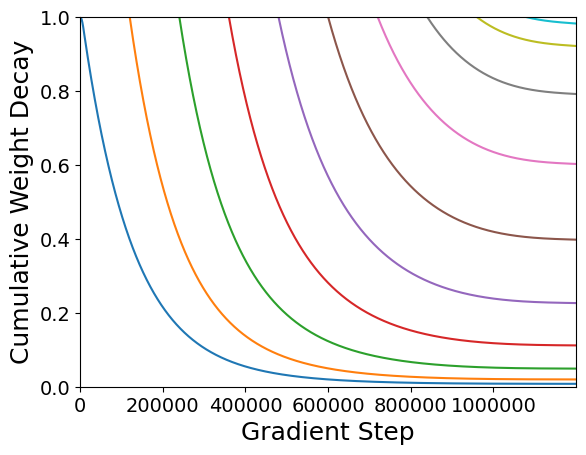

In [11]:
max_lr = 8e-5
min_lr = 8e-7
warmup_steps = 8000
weight_decay = 0.1
total_steps = 1200000

# plot the decay after 0%; 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90% of the steps, all in one plot with one line per percentage
for i in range(0, 100, 10):
    step_start = int(i / 100 * total_steps)
    decay_factor = get_adamw_decay_factors(step_start, total_steps, total_steps, weight_decay, warmup_steps, max_lr, min_lr, get_lr=cosine_lr_schedule)
    x = np.arange(step_start, total_steps)
    plt.plot(x, decay_factor, linestyle='-')
plt.ylim(0, 1)
plt.xlim(0, total_steps)
# plt.title("Llama 3 405B Cumulative Weight Decay (assumes wd=0.1)")
# plt.legend(["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"])
plt.xlabel("Gradient Step")

plt.ylabel("Cumulative Weight Decay")

#x ticks
x = np.arange(0, total_steps, 200000)
plt.xticks(x, x)

# save figure
plt.savefig("figures/LLama3_405B_wd.pdf")
plt.show()